<a href="https://colab.research.google.com/github/HyunaShin/ImageStudy/blob/master/Plant_Seeding_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# api_token = {"username":"hyuna1615","key":"471ac110008706a0be1f1d4f780e4edd"}
# ! chmod 600 /root/.kaggle/kaggle.json
import json
import zipfile
import os

with open('/root/.kaggle/kaggle.json', 'w') as file:
   json.dump(api_token, file)
! kaggle competitions download -c plant-seedlings-classification

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
! ls

sample_data	       sample_submission.csv.zip  test.zip  train.zip
sample_submission.csv  test			  train


In [0]:
! unzip test.zip && unzip train.zip
! unzip sample_submission.csv.zip

Archive:  test.zip
   creating: test/
  inflating: test/c0461776c.png      
  inflating: test/4bbfd1e05.png      
  inflating: test/1d0cbd819.png      
  inflating: test/93079d970.png      
  inflating: test/856f2910a.png      
  inflating: test/976e4e079.png      
  inflating: test/b31292706.png      
  inflating: test/29bab7cad.png      
  inflating: test/37297a64c.png      
  inflating: test/f2dc546ca.png      
  inflating: test/b6a3f7876.png      
  inflating: test/8874bba69.png      
  inflating: test/1459e96a0.png      
  inflating: test/9a3f20121.png      
  inflating: test/5315c2dca.png      
  inflating: test/b7a7f6390.png      
  inflating: test/20e562fd5.png      
  inflating: test/e3f50adfc.png      
  inflating: test/6ba4ef411.png      
  inflating: test/acdb75e00.png      
  inflating: test/e0ec5b6a1.png      
  inflating: test/219fd68d5.png      
  inflating: test/41f1c3cdb.png      
  inflating: test/8c98a6e9b.png      
  inflating: test/1bf9b94a6.png      
  inflating:

In [0]:
import os
os.listdir()

['.config',
 'sample_submission.csv',
 'test.zip',
 'train',
 'train.zip',
 'sample_submission.csv.zip',
 'gdrive',
 'test',
 'sample_data']

In [0]:
! cd train && ls

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [0]:
! find train -type f | wc -l

4750


In [0]:
! find test -type f | wc -l

794


In [0]:
#importing all the necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
from glob import glob
import itertools


from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

scale = 70
seed = 7

In [0]:
#getting the data and resizing the images
path_to_images = "./train/*/*.png"
images = glob(path_to_images)

trainingset = []
traininglabels = []
num = len(images)
count = 1

for i in images:
  print(str(count)+'/'+str(num), end = "\r" )
  trainingset.append(cv2.resize(cv2.imread(i), (scale, scale)))
  traininglabels.append(i.split("/")[-2])
  count = count +1
 
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

In [0]:
# trainingset.shape, trainingset[0]
trainingset.shape, traininglabels.shape

((4750, 70, 70, 3), (4750, 1))

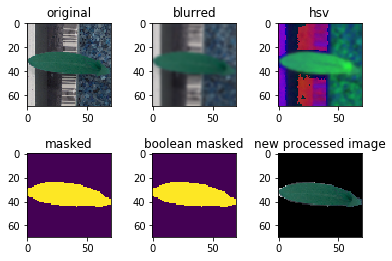

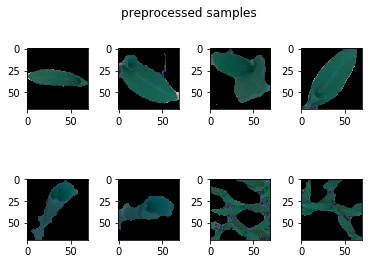

In [0]:
#preprocessing images and remove the background


new_train = []
sets = []; getEx = True

for i in trainingset:
  blurr = cv2.GaussianBlur(i,(5,5),0) #aussianBlur --> 엣지 검출, 영상처리 과정에서 큰 영향, Canny Detection으로 선만 따올수도 있음
  hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
  # GREEN PARAMETERS
  lower = (25,40,50)
  upper = (75,255,255)
  mask = cv2.inRange(hsv, lower, upper)
  struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
  mask =cv2.morphologyEx(mask, cv2.cv2.MORPH_CLOSE, struc)
  boolean = mask > 0
  new = np.zeros_like(i, np.uint8)
  new[boolean] = i[boolean]
  new_train.append(new)
  
  if getEx:
    plt.subplot(2,3,1);plt.imshow(i), plt.title("original")
    plt.subplot(2,3,2);plt.imshow(blurr), plt.title("blurred")
    plt.subplot(2,3,3);plt.imshow(hsv), plt.title('hsv')
    plt.subplot(2,3,4);plt.imshow(mask), plt.title("masked")
    plt.subplot(2,3,5);plt.imshow(boolean), plt.title('boolean masked')
    plt.subplot(2,3,6);plt.imshow(new) , plt.title('new processed image')
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.show()
    getEx = False
    
new_train = np.asarray(new_train)


for i in range(8):
  plt.suptitle("preprocessed samples")
  plt.subplot(2,4, i+1)
  plt.imshow(new_train[i])
  plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


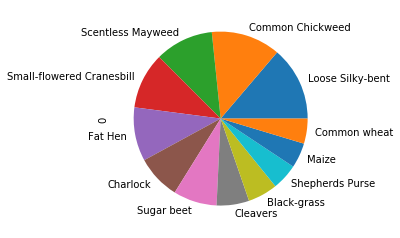

In [0]:
# converting the labels into numbers

labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print("Classes" + str(labels.classes_))

encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))

traininglabels[0].value_counts().plot(kind = 'pie')

In [0]:
# defining our model and splitting the dataset

new_train = new_train/255
x_train, x_test, y_train, y_test = train_test_split(new_train, clearalllabels, test_size = 0.1, random_state = seed, stratify = clearalllabels)

In [0]:
# prevent overfitting

generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1, width_shift_range = 0.1, height_shift_range = 0.1 , horizontal_flip = True,
                              vertical_flip = True )

generator.fit(x_train)

In [0]:
# Defining the Convolutional Neural Network
# 4 Convolution Layers, 3 Fully Connected layers


np.random.seed(seed)
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), input_shape = (scale, scale, 3), activation = "relu")) # 필터 + activation func.세팅
model.add(BatchNormalization(axis = 3)) # 이파리색깔을 batch단위로 정규분포화 시킴
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = "relu"))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization(axis = 3))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 128, kernel_size=(5,5), activation="relu"))
model.add(BatchNormalization(axis = 3))
model.add(Conv2D(filters = 128, kernel_size= (5,5) , activation = "relu"))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization(axis = 3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5,5) , activation = "relu"))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5,5) , activation = "relu"))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization(axis = 3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation = "softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_17 (Batc (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 27, 27, 128)       204928    
__________

In [0]:
# import os
# os.listdir("./gdrive/My Drive")
# # /content/gdrive/'My Drive'/ColabNotebooks/deep_learning/

In [0]:
lrr = ReduceLROnPlateau(monitor='val_acc', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.00001)

filepath="/content/gdrive/My Drive/ColabNotebooks/deep_learning/weights.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoints = ModelCheckpoint(filepath, monitor='val_acc', 
                              verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoints, lrr]

model.fit_generator(generator.flow(x_train, y_train, batch_size = 75), epochs = 35, validation_data = (x_test, y_test), steps_per_epoch = x_train.shape[0], callbacks = callbacks_list)

Epoch 1/35
4275/4275 [==============================] - 466s 109ms/step - loss: 0.1830 - acc: 0.9301 - val_loss: 0.2727 - val_acc: 0.9053

Epoch 00001: val_acc improved from -inf to 0.90526, saving model to /content/gdrive/My Drive/ColabNotebooks/deep_learning/weights.best_01-0.91.hdf5
Epoch 2/35
4275/4275 [==============================] - 462s 108ms/step - loss: 0.1331 - acc: 0.9490 - val_loss: 0.2919 - val_acc: 0.9179

Epoch 00002: val_acc improved from 0.90526 to 0.91789, saving model to /content/gdrive/My Drive/ColabNotebooks/deep_learning/weights.best_02-0.92.hdf5
Epoch 3/35
4275/4275 [==============================] - 463s 108ms/step - loss: 0.1009 - acc: 0.9613 - val_loss: 0.3266 - val_acc: 0.9137

Epoch 00003: val_acc did not improve from 0.91789
Epoch 4/35
4275/4275 [==============================] - 461s 108ms/step - loss: 0.0802 - acc: 0.9694 - val_loss: 0.3938 - val_acc: 0.9011

Epoch 00004: val_acc did not improve from 0.91789
Epoch 5/35
4275/4275 [=======================

In [0]:
! ls

gdrive	     sample_submission.csv	test	  train
sample_data  sample_submission.csv.zip	test.zip  train.zip


In [0]:
# from google.colab import drive

# drive.mount('/content/gdrive')
! cd /content/gdrive/'My Drive'/ColabNotebooks/deep_learning && ls

'Classifier-Dog or Cat.ipynb'   weights.best_01-0.91.hdf5
 plant_seeding_baseline.h5      weights.best_02-0.92.hdf5
 Plant_Seeding_Baseline.ipynb   weights.best_06-0.93.hdf5
 Untitled0.ipynb	        weights.best_08-0.94.hdf5


In [0]:
model.load_weights("/content/gdrive/My Drive/ColabNotebooks/deep_learning/weights.best_08-0.94.hdf5")

In [0]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [0]:
from sklearn.metrics import f1_score

# f1_score(), y_test, average = "micro")
test = np.argmax(model.predict(x_test), axis = 1)
f1_score(test, np.argmax(y_test, axis = 1) , average = "micro")


0.9431578947368421

In [0]:
model.evaluate(x_test, y_test, batch_size = 75)

475/475 [==============================] - 1s 1ms/step


[0.2503438007674719, 0.9431578987523129]

In [0]:
# PREDICTIONS
y_pred = model.predict(x_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[12  0  0  0  0  0 14  0  0  0  0  0]
 [ 0 39  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 59  0  0  0  1  0  0  0  0]
 [ 0  0  0  0 21  0  0  0  0  0  0  1]
 [ 0  0  0  0  0 47  0  0  0  0  0  0]
 [ 5  0  0  0  0  0 60  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 22  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 52  0  0  0]
 [ 0  0  0  2  0  0  0  0  0 21  0  0]
 [ 0  1  0  1  0  0  0  0  0  0 48  0]
 [ 0  0  0  0  0  0  0  1  0  0  0 38]]


In [0]:
path_to_test = './test/*.png'
pics = glob(path_to_test)

testimages = []
tests = []
count=1
num = len(pics)

for i in pics:
    print(str(count)+'/'+str(num),end='\r')
    tests.append(i.split('/')[-1])
    testimages.append(cv2.resize(cv2.imread(i),(scale,scale)))
    count = count + 1

testimages = np.asarray(testimages)

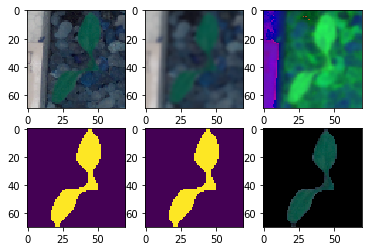

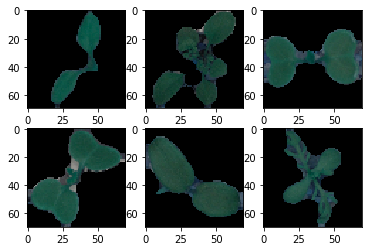

In [0]:
newtestimages = []
sets = []
getEx = True
for i in testimages:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    masking = np.zeros_like(i,np.uint8)
    masking[boolean] = i[boolean]
    newtestimages.append(masking)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i)
        plt.subplot(2,3,2);plt.imshow(blurr)
        plt.subplot(2,3,3);plt.imshow(hsv)
        plt.subplot(2,3,4);plt.imshow(mask)
        plt.subplot(2,3,5);plt.imshow(boolean)
        plt.subplot(2,3,6);plt.imshow(masking)
        plt.show()
        getEx=False

newtestimages = np.asarray(newtestimages)
# OTHER MASKED IMAGES
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(newtestimages[i])

In [0]:
newtestimages=newtestimages/255
prediction = model.predict(newtestimages)
# PREDICTION TO A CSV FILE
pred = np.argmax(prediction,axis=1)
predStr = labels.classes_[pred]
result = {'file':tests,'species':predStr}
result = pd.DataFrame(result)
result.to_csv("Prediction.csv",index=False)

In [0]:
from google.colab import files
files.download("Prediction.csv")

In [0]:
#getting the data and resizing the images
path_to_images = "./test/*.png"
images = glob(path_to_images)

test_set = []
num = len(images)
count = 1

for i in images:
  print(str(count)+'/'+str(num), end = "\r" )
  test_set.append(cv2.resize(cv2.imread(i), (scale, scale)))
  count = count +1
 
testset = np.asarray(test_set)

In [0]:
testset.shape

(794, 70, 70, 3)

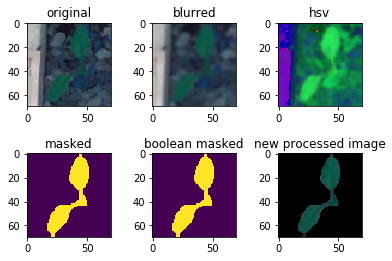

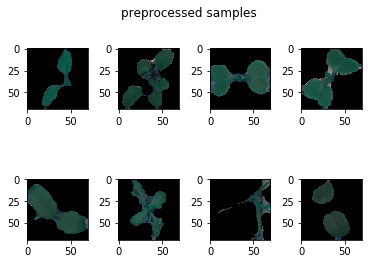

In [0]:
#preprocessing images and remove the background

import matplotlib.pyplot as plt


new_test = []
getEx = True

for i in testset:
  blurr = cv2.GaussianBlur(i,(5,5),0) #aussianBlur --> 엣지 검출, 영상처리 과정에서 큰 영향, Canny Detection으로 선만 따올수도 있음
  hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
  # GREEN PARAMETERS
  lower = (25,40,50)
  upper = (75,255,255)
  mask = cv2.inRange(hsv, lower, upper)
  struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
  mask =cv2.morphologyEx(mask, cv2.cv2.MORPH_CLOSE, struc)
  boolean = mask > 0
  new = np.zeros_like(i, np.uint8)
  new[boolean] = i[boolean]
  new_test.append(new)
  
  if getEx:
    plt.subplot(2,3,1);plt.imshow(i), plt.title("original")
    plt.subplot(2,3,2);plt.imshow(blurr), plt.title("blurred")
    plt.subplot(2,3,3);plt.imshow(hsv), plt.title('hsv')
    plt.subplot(2,3,4);plt.imshow(mask), plt.title("masked")
    plt.subplot(2,3,5);plt.imshow(boolean), plt.title('boolean masked')
    plt.subplot(2,3,6);plt.imshow(new) , plt.title('new processed image')
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.show()
    getEx = False
    
new_test = np.asarray(new_test)


for i in range(8):
  plt.suptitle("preprocessed samples")
  plt.subplot(2,4, i+1)
  plt.imshow(new_test[i])
  plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

In [0]:
new_test.shape

(794, 70, 70, 3)

In [0]:
pred = model.predict(new_test)
import pandas as pd
pd.read_csv("sample_submission.csv").head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet


In [0]:
# import numpy as np
# class_labels = np.argmax(pred, axis=1)
# label_names = dict(enumerate(labels.classes_))
# predicted_label = list(map(lambda x : label_names[x], class_labels))

# pd.DataFrame({"file" : os.listdir('./test/'),"species" : predicted_label }).sort_values(by = "file").to_csv("first_submission2.csv", index = False)
# np.array(os.listdir('./test/')).shape , np.array(predicted_label).shape
# os.listdir("./test")


['d8f4923f8.png',
 '97844bfd5.png',
 '2b55a2da2.png',
 '78750e0ff.png',
 '22e79540f.png',
 '17529c555.png',
 'bb1c84bbc.png',
 'e3f50adfc.png',
 '59358cd44.png',
 'ef3e232ad.png',
 'ef65533d5.png',
 '54b3afd58.png',
 '1364b297a.png',
 'd7017f701.png',
 '6b721f68e.png',
 '24d36c52c.png',
 'f48916a8c.png',
 'fea355851.png',
 '7beb2766f.png',
 'beebe5f4e.png',
 'c10ccbd82.png',
 '1821eb11a.png',
 '711b46fba.png',
 'e0ec5b6a1.png',
 'a8388a37f.png',
 '2f0004a7f.png',
 '4bcdaa5e2.png',
 '5883b423d.png',
 'a8b431a3e.png',
 'ef9676433.png',
 'f2dc546ca.png',
 'd9c50616e.png',
 '05341a8a6.png',
 'b7192c70f.png',
 '76555b064.png',
 '53ceb4657.png',
 'a0b393945.png',
 '4ac29bbf0.png',
 'da713c465.png',
 'b687160f5.png',
 'cb496f36e.png',
 'd6d31dcbe.png',
 '8e6ec1ca6.png',
 '71e73a8a0.png',
 '5bc6595f6.png',
 '6da892be6.png',
 '17d5e5ac4.png',
 'c6c8d4ba0.png',
 'a060c1cf8.png',
 '6d6eb3830.png',
 'd93c7ab6d.png',
 '55920f07f.png',
 '9d79a1f0c.png',
 '3526b05cc.png',
 'f4021df6c.png',
 'ef02b4ee

In [0]:
np.unique(np.asarray(predicted_label))

array(['Common Chickweed', 'Fat Hen', 'Maize',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')

In [0]:
pd.DataFrame(y_train , columns = labels.classes_).sum()

Black-grass                  237.0
Charlock                     351.0
Cleavers                     258.0
Common Chickweed             550.0
Common wheat                 199.0
Fat Hen                      428.0
Loose Silky-bent             589.0
Maize                        199.0
Scentless Mayweed            464.0
Shepherds Purse              208.0
Small-flowered Cranesbill    446.0
Sugar beet                   346.0
dtype: float32

In [0]:
pd.DataFrame({"file" : os.listdir('./test/'),"species" : predicted_label }).sort_values(by = "file")

,file,species
791,0021e90e4.png,Common Chickweed
124,003d61042.png,Common Chickweed
733,007b3da8b.png,Common Chickweed
577,0086a6340.png,Common Chickweed
262,00c47e980.png,Common Chickweed
714,00d090cde.png,Common Chickweed
151,00ef713a8.png,Common Chickweed
592,01291174f.png,Common Chickweed
314,026716f9b.png,Small-flowered Cranesbill
122,02cfeb38d.png,Maize


In [0]:
from google.colab import files
files.download("first_submission2.csv")